# Exemplos INF-0618 Aula 01

Based on: https://github.com/ardendertat/Applied-Deep-Learning-with-Keras

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from __future__ import print_function
from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


## Utility Functions

These are the plotting helper functions used further down in the notebook. You don't need to fully understand what's going on here to get the big picture. The names of the functions are self-explanatory. I would at first recommend to skip this part and proceed to the next Logistic Regression section.

In [2]:
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 301), np.linspace(y_min, y_max, 301))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))
     
def make_sine_wave():
    c = 3
    num = 2400
    step = num/(c*4.0)
    np.random.seed(0)
    x0 = np.linspace(-c*np.pi, c*np.pi, num)
    x1 = np.sin(x0)
    noise = np.random.normal(0, 0.1, num) + 0.1
    noise = np.sign(x1) * np.abs(noise)
    x1  = x1 + noise
    x0 = x0 + (np.asarray(range(num)) / step) * 0.3
    X = np.column_stack((x0, x1))
    y = np.asarray([int((i/step)%2) for i in range(len(x0))])
    return X, y

def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y

We will use the *Sequential* model API available [here](https://keras.io/getting-started/sequential-model-guide/). The Sequential model allows us to build deep neural networks, by stacking layers one top of another.

In Keras we don't add layers corresponding to input nodes, we only do for hidden nodes and output nodes.

The *Dense* function in Keras constructs a fully connected neural network layer, automatically initializing the weights as biases. The function arguments are defined as follows:
- *units*: The first argument, the number of nodes in this layer. Since we're constructing the output layer, and we said it has only one node, this value is 1.
- *input_shape*: The first layer in Keras models need to specify the input dimensions. The subsequent layers (which we don't have here but we will in later sections) don't need to specify this argument because Keras can infer their dimensions automatically. In this our input dimensionality is 2, the x and y coordinates. The input_shape parameter expects a vector, so in our case it's simply a tuple with one number.
- *activation*: The activation function of a logistic regression model is the *logistic* function, or altenatively called as *sigmoid*. We will explore different activation functions and where to use them and why in another tutorial.

We then compile the Keras model with the *compile* function. This creates the neural network model by configuring the learning process. The model hasn't been trained yet. Right now we're specifying the optimizer to use and the loss function to minimize. The arguments for the compile function are defined as follows:
- *optimizer*: Which optimizer to use in order to minimize the loss function. There are a lot of different optimizers, most of them based on gradient descent. For now we will use the *adam* optimizer, which is the one people prefer to use by default.
- *loss*: The loss function to minimize. Since we're building a binary 0/1 classifier, the loss function to minimize is *binary_crossentropy*.
- *metrics*: Which metric to report statistics on, for classification problems we set this as *accuracy*.

Now comes the fun part of actually training the model. The arguments are as follows:
- *x*: The input data, we defined it as *X* above. It contains the x and y coordinates of the input points
- *y*: Not to be confused with the y coordinate of the input points. In the tutorials you see online *y* refers the the labels, in our case the class we're trying to predict: 0 or 1.
- *verbose*: Prints out the loss and accuracy, set it to 1 to see the output.
- *epochs*: Number of times to go over the training data. When training models we pass through the training data not just once but multiple times.

The output of the fit method is the loss and accuracy at every epoch. We then plot it to see that the loss goes down to almost 0 over time, and the accuracy goes up to almost 1.

## Training a Neural Network

We will train a deep Artificial Neural Network (ANN) to classify datasets: Moons, Circles, and Sine Wave. Then we'll train a ANN for a multiclass dataset.

### Moons

Let's perform the following steps:
- Step 1: Define a Sequential model.</p>
- Step 2: Add several Dense layers with activation functions.</p>
- Step 3: Compile the model with an optimizer and loss function.</p>
- Step 4: Fit the model to the dataset.</p>
- Step 5: Analyze the results: plotting loss/accuracy curves, plotting the decision boundary, looking at the classification report, and understanding the confusion matrix.</p>

<!---
We will add several Dense layers one after another. The output of one layer becomes the input of the next. Keras again does most of the heavylifting of initializing the weights and biases, and connecting the output of one layer to the input of the next. We only need to specify how many nodes we want in that layer, and the activation function.

As you can see we first add a layer with 4 nodes and *tanh* activation function. We then add another layer with 2 nodes and again tanh activation. We finally add the last layer with 1 node and sigmoid activation.

This is not a very deep ANN, it only has 3 layers: input layer, 1 hidden layer, and the output layer. But notice a couple of patterns:
- Output layer still uses the sigmoid activation function since we're working on a binary classification problem.
- Non-output layers use the tanh activation function. If we added more hidden layers, they would also have tanh activation.
- We have fewer number of nodes in each subsequent layer. It's common to have less nodes as we stack layers on top of one another.

We didn't build a very deep ANN here because it wasn't necessary. We already achieve perfect accuracy with this configuration.
-->

In [3]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=0)

In [4]:
# Define your model here
model = Sequential()
model.add(Dense(4, input_shape=(2,), activation='tanh'))
model.add(Dense(2, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

# Model compilation
model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

<Figure size 576x432 with 0 Axes>

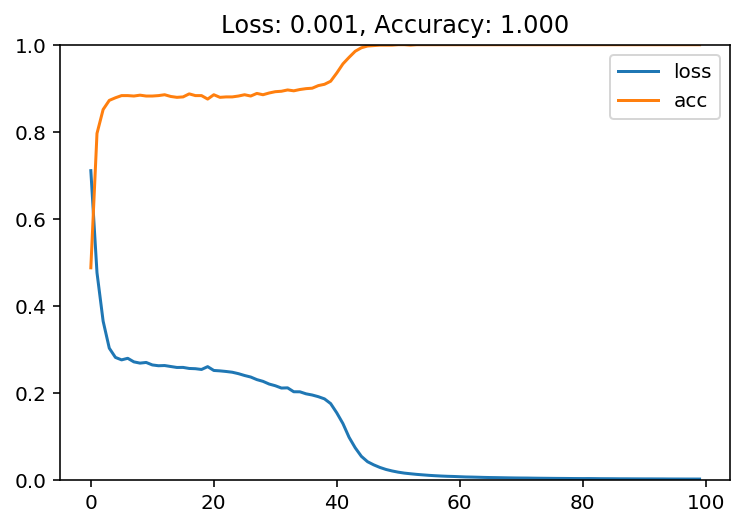

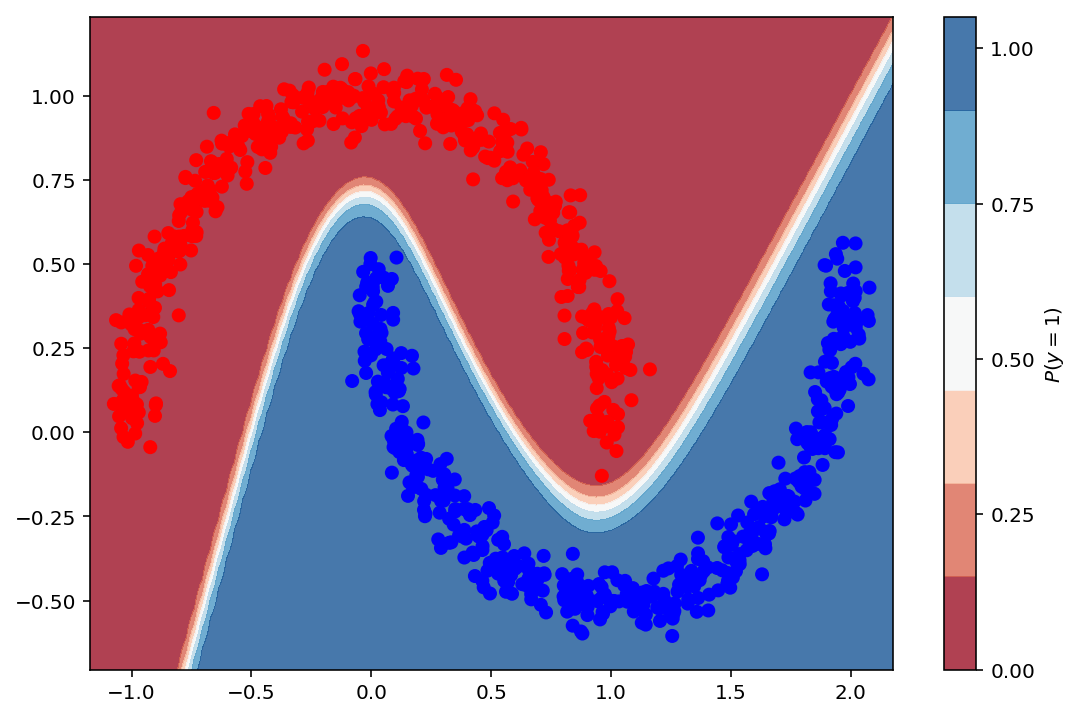

In [5]:
history = model.fit(X, y, verbose=0, epochs=100)
plot_loss_accuracy(history)
plot_decision_boundary(lambda x: model.predict(x), X, y)

In [6]:
y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       500
          1       1.00      1.00      1.00       500

avg / total       1.00      1.00      1.00      1000



### Circles

Now let's look at the Circles dataset. The model is the same as above, we only change the input to the fit function.

In [21]:
X, y = make_circles(n_samples=1000, noise=0.05, factor=0.3, random_state=0)

In [23]:
# Define your model here
# Define your model here
model = Sequential()
model.add(Dense(5, input_shape=(2,), activation='tanh'))
model.add(Dense(5, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

# Model compilation
model.compile(Adam(lr=0.01), 'binary_crossentropy', metrics=['accuracy'])

<Figure size 576x432 with 0 Axes>

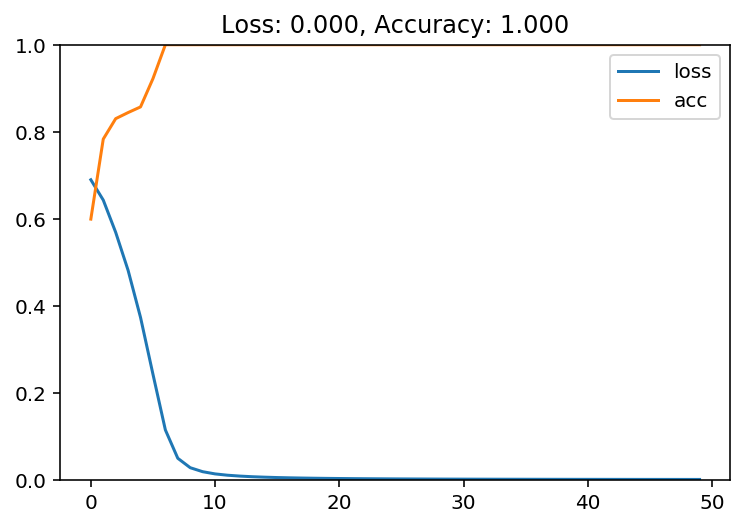

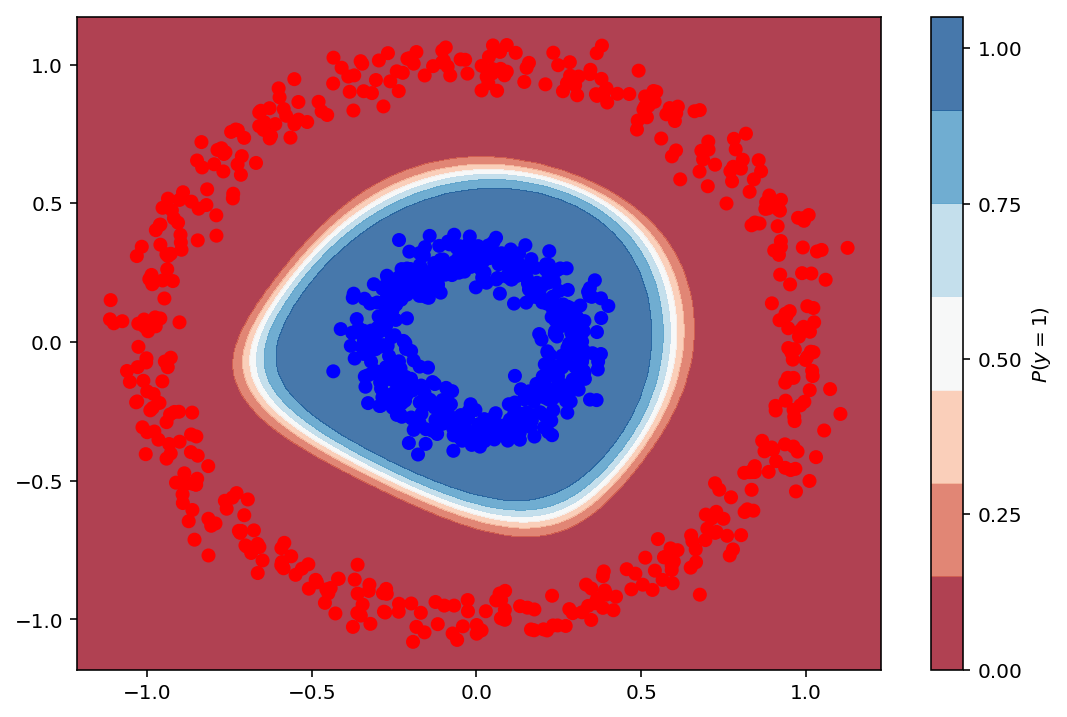

In [24]:
history = model.fit(X, y, verbose=0, epochs=50)

plot_loss_accuracy(history)
plot_decision_boundary(lambda x: model.predict(x), X, y)

In [25]:
y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       500
          1       1.00      1.00      1.00       500

avg / total       1.00      1.00      1.00      1000



## Sine Wave

Let's try to classify one final toy dataset, and then we will move on to a real-world example.

Let's create a sinusoidal dataset looking like the sine function, every up and down belongs to an alternating class. As we can see in the figure, a single decision boundary won't be able to separate out the classes. We will need a series of non-linear boundaries.

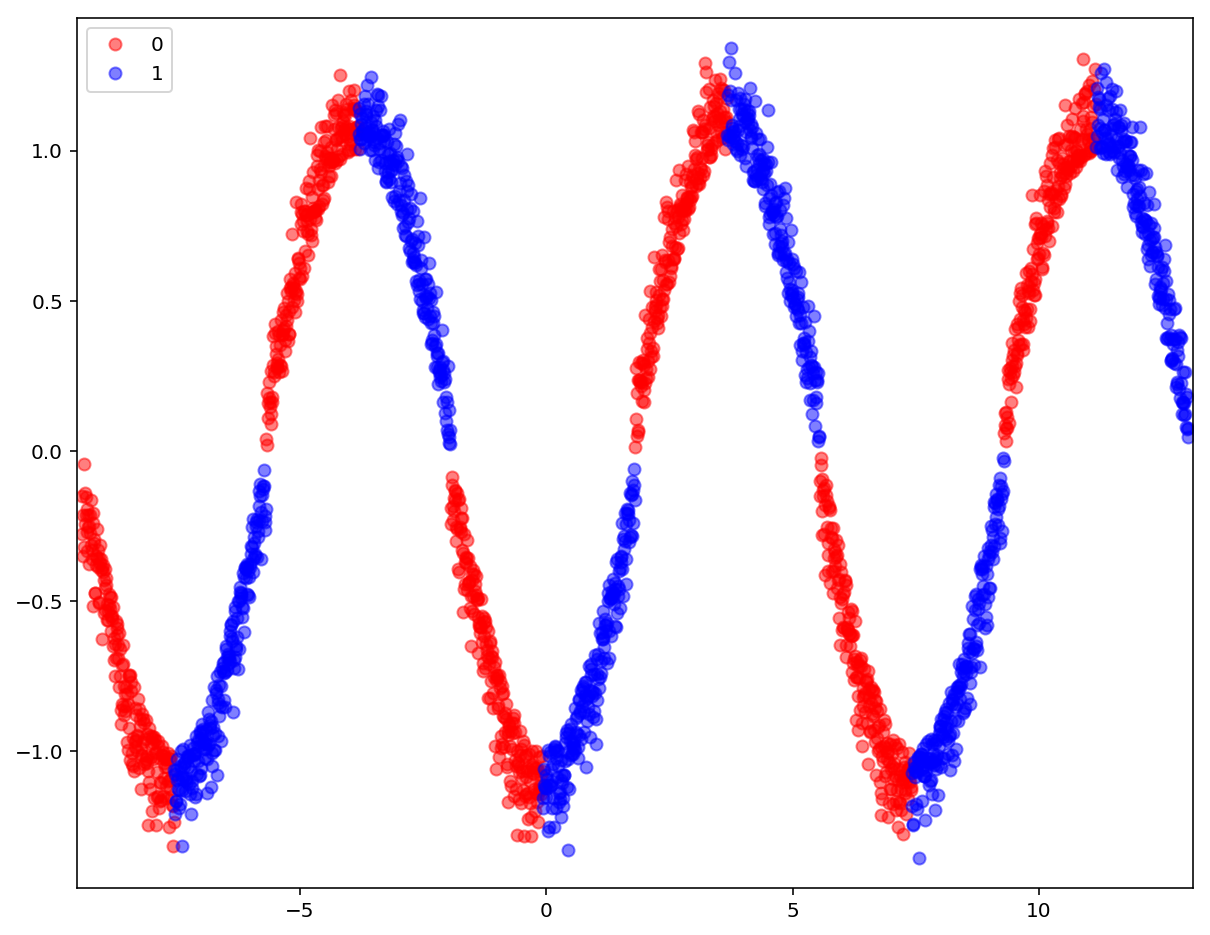

In [26]:
X, y = make_sine_wave()

plot_data(X, y, figsize=(10, 8))

Now we need a more complex model for accurate classification. So we have an input layer, 2 hidden layers, and an output layer. The number of nodes per layer has also increased to improve the learning capacity of the model.

In [29]:
# Define your model here
model = Sequential()
model.add(Dense(128, input_shape=(2,), activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

# Model compilation
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

<Figure size 576x432 with 0 Axes>

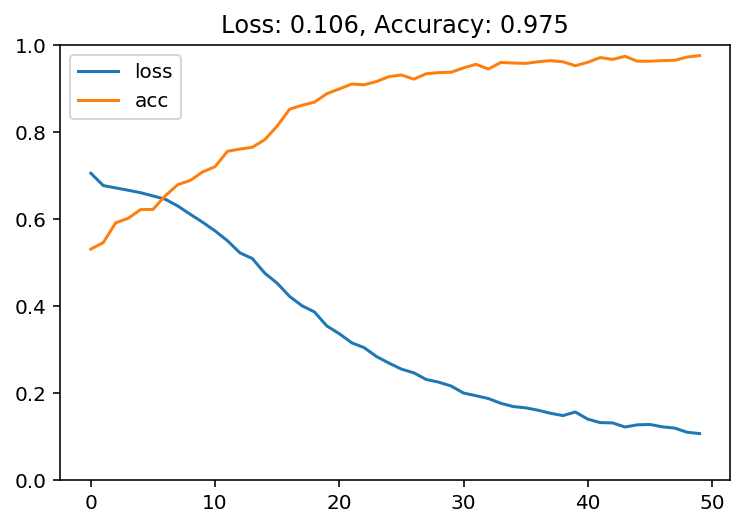

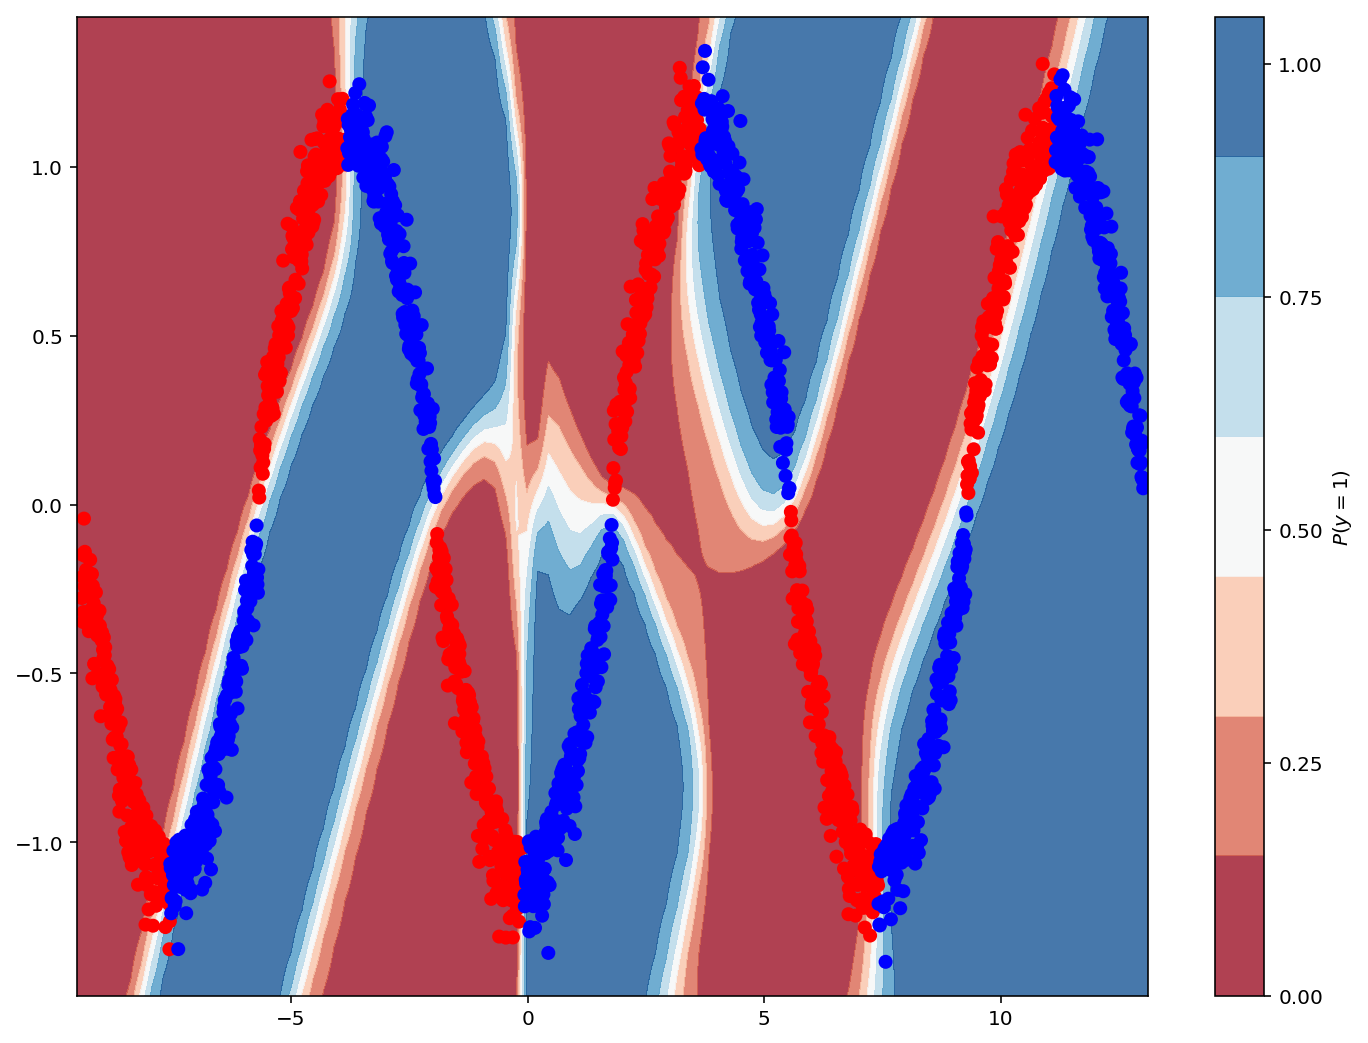

In [30]:
history = model.fit(X, y, verbose=0, epochs=50)

plot_loss_accuracy(history)
plot_decision_boundary(lambda x: model.predict(x), X, y, figsize=(12, 9))

In [14]:
y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

          0       0.97      0.96      0.97      1200
          1       0.96      0.97      0.97      1200

avg / total       0.97      0.97      0.97      2400



## Multiclass Classification

In the previous sections we worked on a binary classification problem. Now we will take a look at a multi-class classification problem, where the number of classes is more than 2. We will pick 3 classes for demonstration, but our approach generalizes to any number of classes.

Here's how our dataset looks like, spiral data with 3 classes.

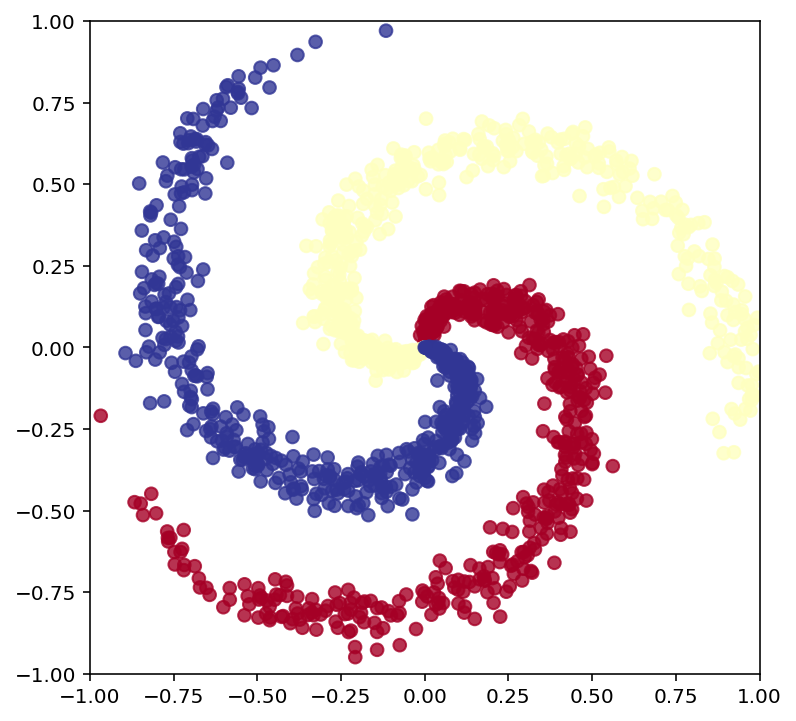

In [15]:
X, y = make_multiclass(K=3)

Now let's build a ANN for multiclass classification. We need to add more Dense layers: add a couple of Dense layers with tanh activation function, decreasing number of nodes per layer.

Notice that the output layer has 3 nodes, and uses the softmax activation. The loss is categorical_crossentropy.

In [16]:
# Define your model here
model = Sequential()
model.add(Dense(128, input_shape=(2,), activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(3, activation='softmax'))

# Model compilation
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])

<Figure size 576x432 with 0 Axes>

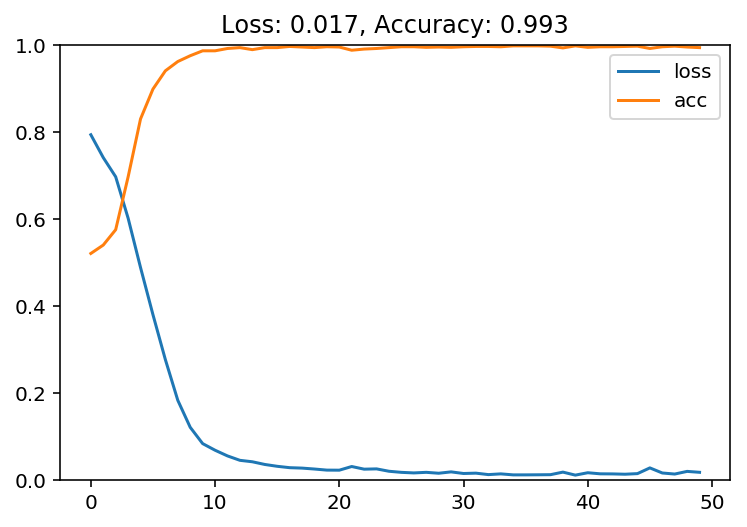

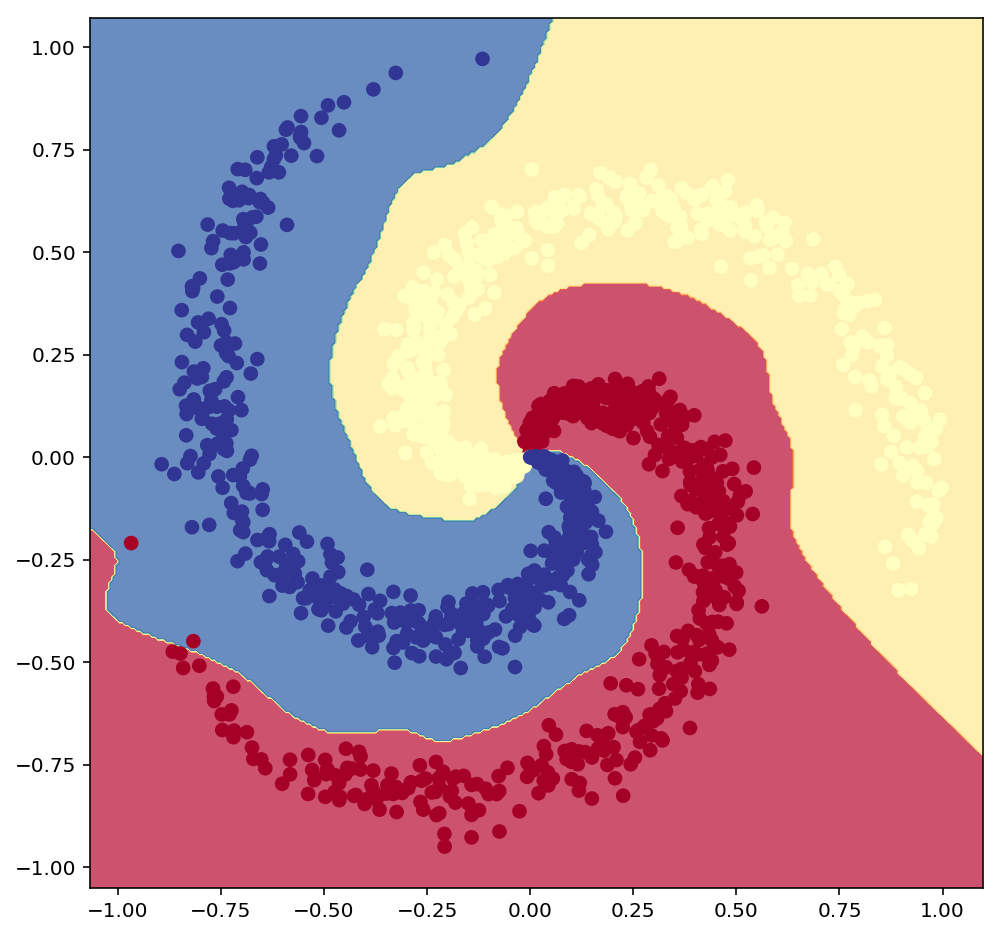

In [17]:
y_cat = to_categorical(y)
history = model.fit(X, y_cat, verbose=0, epochs=50)

plot_loss_accuracy(history)
plot_multiclass_decision_boundary(model, X, y)

In [18]:
y_pred = model.predict_classes(X, verbose=0)
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

        0.0       1.00      0.99      0.99       500
        1.0       1.00      0.98      0.99       500
        2.0       0.97      1.00      0.99       500

avg / total       0.99      0.99      0.99      1500

